# Template for Practical work on the Conversion of sampling frequency and STFT


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2020*

**python version : 3.6**

In [1]:
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write

## Functions

In [2]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [3]:
data_path = os.getcwd()
filename = 'caravan_48khz.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [4]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805733, comptype='NONE', compname='not compressed')


In [ ]:
play = True
if play :
    play_sound(sound) 

In [5]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [6]:
timestep = 1/float(Fs)
times = np.arange(x.shape[0])*timestep

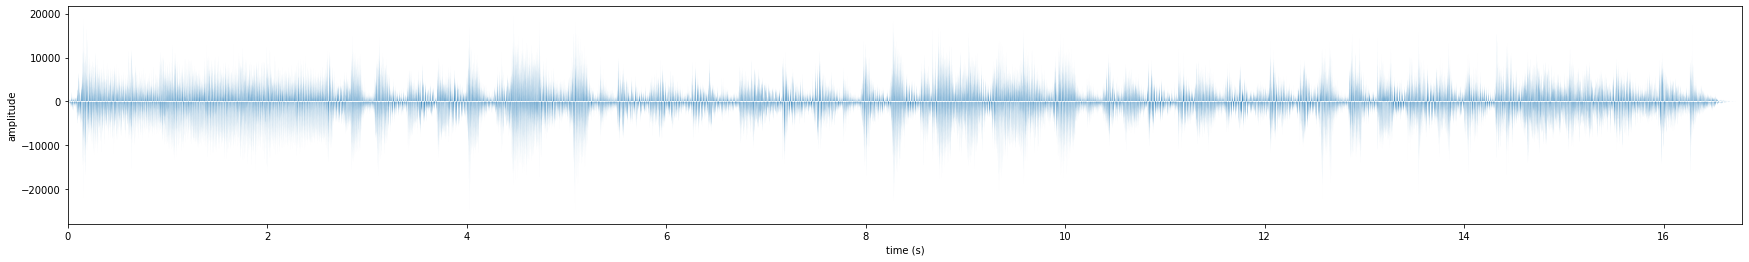

In [7]:
plot_sound(x, times)

In [25]:
write('new_caravan_efficient.wav', Fs, np.array(y, dtype=np.int16)) # to write a new wave file

## Signal analysis with the STFT

In [24]:
N = x.shape[0] # % longueur du signal
Nw = 512
w = np.hanning(Nw) # définition de la fenetre d'analyse
ws = w.copy; # définition de la fenêtre de synthèse
R = 1 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
M = 32 # ordre de la tfd
L = M/2+1
affich = 1 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse

if affich:
    Xtilde = np.zeros((M,Nt),dtype=complex)

In [9]:
for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 # début de trame
    fin = deb + Nw # fin de trame
    tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w) # calcul de la trame 
    X = np.fft.fft(tx,M) # tfd à l'instant b
    if affich:
        Xtilde[:,u] = X
    # opérations de transformation (sur la partie \nu > 0)
    # ....
    Y = X.copy
    # fin des opérations de transformation
    # resynthèse
    # overlap add

def extents(f):
  delta = f[1] - f[0]
  return [f[0] - delta/2, f[-1] + delta/2]

In [ ]:
if affich:
    plt.imshow(20*np.log10(np.abs(Xtilde[np.arange(0,L),:])), aspect='auto',interpolation='none',
               origin='lower', extent=[0, Nt * R / Fs + Nw / 2, 0, Fs/2])
    

## Overlap-add reconstruction

In [10]:
def ola(w = None,hop = None,Nb = 10): 
# function output = ola(w,hop,Nb)
# realise l'addition-recouvrement de la fenetre w,
# avec un décalage hop et un nombre Nb de fenetres.
# par defaut Nb = 10;
    
    w = w[:, np.newaxis]
    N = len(w)
    output = np.zeros(((Nb - 1) * hop + N,1)) # réserve l'espace memoire
    
    for k in np.arange(0,Nb).reshape(-1):
        deb = k* hop
        fin = deb + N
        output[np.arange(deb,fin)] = output[np.arange(deb,fin)] + w # OLA
    
    return output

## Answers

In [11]:
#Imports

import scipy.signal
import time

### 1 - Conversion of sampling rate

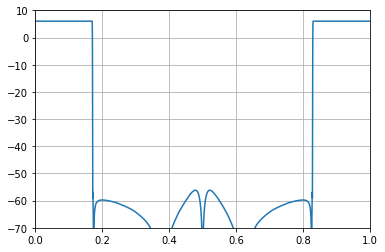

In [20]:
#1. 

## We want to resample from 48 kHz to 32 kHz. Therefore, the rate is L/M = 2/3. As a result h should be a low-pass filter with cut off frequency 1/6.

L = 2
M = 3
length = 2000
nu_c = 0.17
nu_a = 1.01*nu_c
h = scipy.signal.remez(length,[0, nu_c, nu_a, .5],[L,0])
H = np.fft.fft(h,length)
freq = [k/length for k in range(length)]

def plot_response(f,tab):
	fig = plt.figure()
	ax = fig.add_subplot(111)
	ax.plot(tab, 20*np.log10(np.abs(f)))
	ax.set_ylim(-70, 10)
	ax.set_xlim(0, 1)
	ax.grid(True)
	
plot_response(H, freq)

In [21]:
#2. 

def Insertion_of_Zeros(x,L):
	w=np.zeros(x.shape[0]*L)
	w[::L] = x
	return w

def Resampling(x,L,M):
	y = scipy.signal.lfilter(h,[1],Insertion_of_Zeros(x,L))  #Application du filtre
	return y[::M] #on ne conserve que les échantillons qui nous intéressent.

	
y=Resampling(x,2,3)


In [22]:
#3 

def Efficient_Resampling(x,h,L=2,M=3):
	# Extension avec des zéros pour éviter tout problème de longueurs différentes des sous suites lorsqu'on passe à des pas différents
	if h.shape[0] % M !=0:
		h= np.append(h, np.zeros((M-h.shape[0]%M,)))

	if x.shape[0] % M !=0:
		x= np.append(x, np.zeros((M-x.shape[0]%M,)))	

	# Application des composants polyphases de type II
	R0=h[::L]
	R1=h[1::L]

	# Préparation de x pour être passé dans chaque chemin du filter bank : application  de z-1 (via les np.roll).
	x0=x[::M]
	x1=np.roll(x[1::M],-(M-1))
	x2=np.roll(x[2::M],-(M-2))

	# Filtrage dans chaque chemin du filter bank en utilisant les composants polyphases de type I sur ceux déjà obtenus précédemment 
	E00=scipy.signal.lfilter(R0[::M],[1],x0)
	E01=scipy.signal.lfilter(R0[1::M],[1],x1)
	E02=scipy.signal.lfilter(R0[2::M],[1],x2)

	E10=scipy.signal.lfilter(R1[::M],[1],x0)
	E11=scipy.signal.lfilter(R1[1::M],[1],x1)
	E12=scipy.signal.lfilter(R1[2::M],[1],x2)

	# Regroupement après insertion de zéros et dernier z-1.
	return Insertion_of_Zeros(E10+E11+E12,L)+np.roll(Insertion_of_Zeros(E00+E01+E02,L),-(M-2))


y=Efficient_Resampling(x,h)



In [23]:
#4. 
"""
L'effet sonore obtenu sur les deux rééchantillonnage est identique.
"""
Resampling_0 = time.time()
for k in range(100):
	y_0 = Resampling(x,2,3)
Resampling_1 = time.time()

Efficient_0 = time.time()
for k in range(100):
	y_1 = Efficient_Resampling(x,h)
Efficient_1 = time.time()

print((Resampling_1 - Resampling_0) - (Efficient_1 - Efficient_0))

"""
D'après le résultat du calcul ci-dessus, utiliser l'implémentation effficace permet de gagner en moyenne 27/100e de seconde sur ce rééchantillonage.
"""

27.09855818748474


"\nD'après le résultat du calcul ci-dessus, utiliser l'implémentation effficace permet de gagner en moyenne 3/10e de seconde sur ce rééchantillonage.\n"

### 2 - STFT audio equalization

#### 2.1 STFT analysis

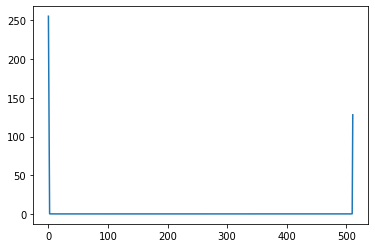

In [139]:
#1. 

Nw = 512
w = np.hanning(Nw)
M = 512
DFT_w = np.fft.fft(w,M)
plt.plot(np.abs(DFT_w))
plt.show()

In [ ]:
#2. 
""" 
En s'intéressant aux deux lignes de code suivantes présentes dans le code du notebook qui correspondent à une boucle sur u: 
    tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w) # calcul de la trame 
    X = np.fft.fft(tx,M) # tfd à l'instant b
Les deb et fin dépendant de u, c'est en fait les échantillons x qui sont translatés du temps d'analyse et non la fenètre.
Il s'agit donc de la seconde convention, dite "passe-bande"
"""

In [127]:
#3. 

for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
	deb = u * R + 1 # début de trame
	fin = deb + Nw # fin de trame
	tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w) # calcul de la trame 
	X = np.fft.fft(tx,M) # tfd à l'instant 
	Xtilde[:,u] = X

X2= np.imag(Xtilde[3,:])
print(X2)

"""
On remarque que Im(x_k(u))<>0 pour k=3 donc il s'agit bien d'un signal complexe
"""


[ 0.01303541  0.03610499  0.02492077 ... -0.04393861 -0.05157041
 -0.04157988]


In [ ]:
play_sound(np.real(X2)) #Ecouter Re(xk)

In [ ]:
#print(scipy.signal.spectrogram(X2))
# Je ne sais pas comment utiliser le spectrogramme pour terminer cette question.

#### 2.2 Reconstruction

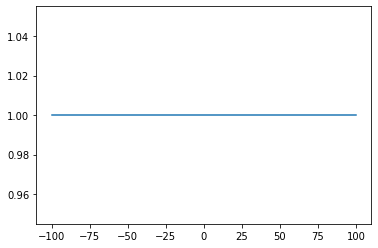

In [12]:
#4.

Normalization_factor = 1/(np.multiply(w,w).sum()**0.5)
w_final = np.multiply(w, Normalization_factor)

def test_Fenetre(n,window):
	u = int((n-Nw)/R)+1
	res=0
	while u<=int(n/R):
		res+=(window[n-u*R])**2
		u+=1
	return res

abs = np.arange(-100,101)
ord = [test_Fenetre(n,w_final) for n in range (-100, 101)]
plt.plot(abs,ord)



<ipython-input-25-5c7d096e3208>:21: ComplexWarning: Casting complex values to real discards the imaginary part
  Reconstructed[n]=y


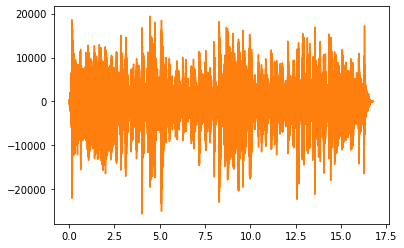

In [25]:
#5. Resynthesis
Xtilde = np.zeros((M,Nt),dtype=complex)

for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 # début de trame
    fin = deb + Nw # fin de trame
    tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w_final) # calcul de la trame 
    X = np.fft.fft(tx,M) # tfd à l'instant b
    Xtilde[:,u] = X

length = Xtilde.shape[1]
Reconstructed = np.zeros((length))
for n in range(length):
	y=0
	for u in range(int((n-Nw)/R)+1, int(n/R)+1):
		ys=0
		p = int(n - u*R)
		for k in range(M):
			ys+=Xtilde[k,u] * np.exp(2j*np.pi*k*p/M)
		y+=ys*w_final[p]/M
	Reconstructed[n]=y

timessignal = np.arange(length)*timestep
plt.plot(timessignal,Reconstructed) #signal reconstruit

timessignal = np.arange(length)*timestep
plt.plot(times,x) #signal initial

	

##### 2.3 STFT audio equalizer

In [ ]:
#6 Equalizer

# Equalizer en ne mettant le poids que sur le channel central

Weight = np.zeros((M))
Weight[M/2]=(M+1)

Xtilde = np.zeros((M,Nt),dtype=complex)
Ytilde = np.zeros((M,Nt),dtype=complex)

for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 # début de trame
    fin = deb + Nw # fin de trame
    tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w_final) # calcul de la trame 
    X = np.fft.fft(tx,M) # tfd à l'instant b
    Xtilde[:,u] = X

length = Xtilde.shape[1]
Reconstructed = np.zeros((length))
for n in range(length):
	y=0
	for u in range(int((n-Nw)/R)+1, int(n/R)+1):
		ys=0
		p = int(n - u*R)
		for k in range(M):
			Ytilde[k,u]=Weight[k]*Xtilde[k,u]
			ys+=Ytilde[k,u] * np.exp(2j*np.pi*k*p/M)
		y+=ys*w_final[p]/M
	Reconstructed[n]=y